<a href="https://colab.research.google.com/github/tusharkj14/Knowledge_Graph_Start/blob/main/SRT_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
import pandas as pd

In [10]:
df_SRT = pd.read_csv('data.csv', sep = '\t', index_col=0)

In [11]:
df_SRT.head()

,Sentences
0,Sachin Ramesh Tendulkar ; born 24 April 1973) ...
1,He is widely regarded as one of the greatest b...
2,He is the highest run scorer of all time in in...
3,"In 2013, he was the only Indian cricketer incl..."
4,He is affectionately known as Little Master or...


In [13]:
import spacy
from spacy import displacy 
import spacy.cli
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [14]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [15]:
def reqd_ents(sent):
  ent1 = ent2 = ""
  prv_tok_dep = prv_tok_text = ""
  prefix = modifier = ""

  for token in nlp(sent):

    if token.dep_ != "punct":

      if token.dep_ == "compound": 

        prefix = token.text 

        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + token.text

      if token.dep_.endswith("mod"):
        modifier = token.text

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + token.text

      if token.dep_.find("subj")==True:
        ent1 = modifier + " " + prefix + " " + token.text
        prefix = modifier = prv_tok_dep = prv_tok_text = ""

      if token.dep_.find("obj")==True:
        ent2 = modifier + " " + prefix + " " + token.text

      prv_tok_text = token.text
      prv_tok_dep = token.dep_

  return [ent1.strip(), ent2.strip()]

In [16]:
entity_pairs = []

In [17]:
for i in tqdm(df_SRT['Sentences']):
  entity_pairs.append(reqd_ents(i))

100%|██████████| 460/460 [00:19<00:00, 23.91it/s]


In [18]:
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [19]:
def get_rlns(sent):
  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP': 'ROOT'},
             {'DEP': 'prep', 'OP':'?'},
             {'DEP':'agent','OP':"?"}, 
             {'POS':'ADJ','OP':"?"}
             ]

  matcher.add("matching_1", None, pattern)

  matches = matcher(doc)
  
  return doc[matches[-1][1]:matches[-1][2]].text

In [20]:
relations = [get_rlns(i) for i in tqdm(df_SRT['Sentences'])]

100%|██████████| 460/460 [00:23<00:00, 19.84it/s]


In [21]:
entity_pairs[:5]

[['international  who', 'national  team'],
 ['He', 'greatest  cricket'],
 ['He', 'international Day cricket'],
 ['he', '150th Wisden Almanack'],
 ['He', 'affectionately Little Master']]

In [24]:
import numpy as np

In [25]:
len(np.unique(np.array(relations)))

248

In [26]:
kg_df = pd.DataFrame({'source':[i[0] for i in entity_pairs],
                      'target':[i[1] for i in entity_pairs],
                      'edge':relations})

In [27]:
kg_df.head()

,source,target,edge
0,international who,national team,is
1,He,greatest cricket,regarded as
2,He,international Day cricket,is
3,he,150th Wisden Almanack,was
4,He,affectionately Little Master,known as


In [32]:
for token in nlp(df_SRT['Sentences'][2]):
  print(f"{token.text}---{token.dep_}")

He---nsubj
is---ROOT
the---det
highest---amod
run---amod
scorer---attr
of---prep
all---det
time---pobj
in---prep
international---amod
cricket---pobj
,---punct
and---cc
the---det
only---amod
player---conj
to---aux
have---aux
scored---relcl
one---compound
hundred---nummod
international---amod
centuries---dobj
,---punct
the---det
first---amod
batsman---appos
to---aux
score---relcl
a---det
double---amod
century---dobj
in---prep
a---det
One---nummod
Day---compound
International---pobj
,---punct
the---det
holder---appos
of---prep
the---det
record---pobj
for---prep
the---det
most---amod
runs---pobj
in---prep
both---preconj
Test---pobj
and---cc
ODI---conj
cricket---conj
,---punct
and---cc
the---det
only---amod
player---conj
to---aux
complete---relcl
more---amod
than---quantmod
30,000---nummod
runs---dobj
in---prep
international---amod
cricket---pobj
.---punct


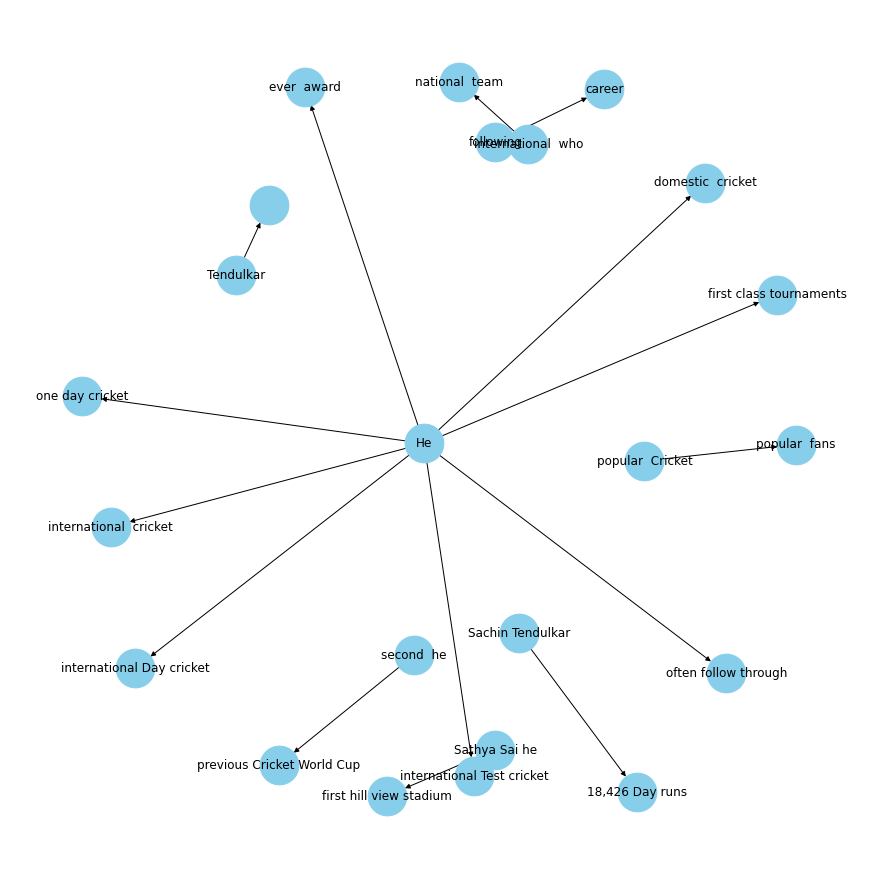

In [33]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"],
                          "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500,
        edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

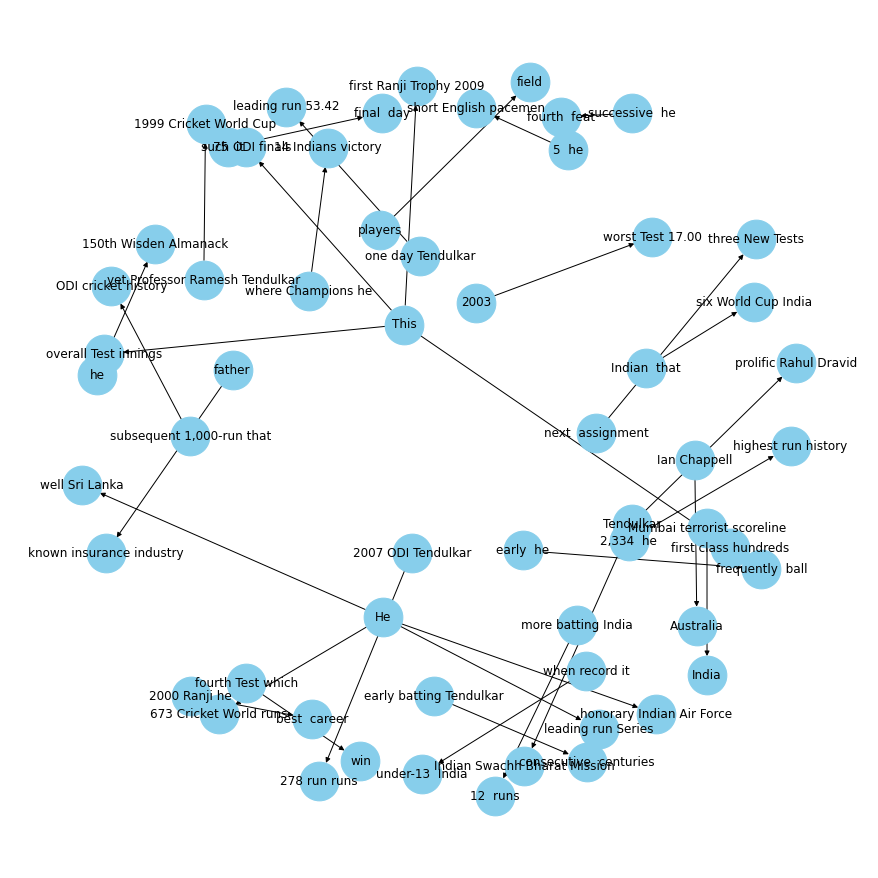

In [34]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="was"],
                          "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500,
        edge_cmap=plt.cm.Blues, pos = pos)
plt.show()